Import the songs from youtube.

In [1]:
import subprocess
import os

def download_youtube_audio_as_wav(youtube_url, output_path="audio.wav"):
    """
    Downloads audio from YouTube using yt-dlp and saves it directly as a WAV file.
    """
    # Command to download and convert to WAV
    command = [
        "yt-dlp",
        "--extract-audio",
        "--audio-format", "wav",
        "--output", output_path,
        youtube_url,
    ]
    subprocess.run(command, check=True)
    return output_path

# Example usage
content_audio_url = "https://www.youtube.com/watch?v=G3lSONLLx70"  # Replace with YouTube URL
style_audio_url = "https://www.youtube.com/watch?v=qrO4YZeyl0I"    # Replace with YouTube URL

content_audio_path = download_youtube_audio_as_wav(content_audio_url, output_path="content_audio.wav")
style_audio_path = download_youtube_audio_as_wav(style_audio_url, output_path="style_audio.wav")

print("Content Audio Path:", content_audio_path)
print("Style Audio Path:", style_audio_path)

Content Audio Path: content_audio.wav
Style Audio Path: style_audio.wav


Load audio

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load the content and style audio
content_audio, sr = librosa.load("content_audio.wav", sr=None)
style_audio, _ = librosa.load("style_audio.wav", sr=sr)  # Ensure consistent sample rate

print(f"Sample Rate: {sr}")
print(f"Content Audio Shape: {content_audio.shape}")
print(f"Style Audio Shape: {style_audio.shape}")

Sample Rate: 48000
Content Audio Shape: (8302592,)
Style Audio Shape: (14801886,)


Compute spectograms.

In [2]:
# Compute STFT for both content and style audio
content_stft = librosa.stft(content_audio)
style_stft = librosa.stft(style_audio)

# Extract magnitude spectrograms
content_spectrogram = np.abs(content_stft)
style_spectrogram = np.abs(style_stft)

# Display spectrogram shapes
print(f"Content Spectrogram Shape: {content_spectrogram.shape}")
print(f"Style Spectrogram Shape: {style_spectrogram.shape}")

Content Spectrogram Shape: (1025, 16217)
Style Spectrogram Shape: (1025, 28910)


Visualize the Spectrograms

Statistics for Content Spectrogram:
  Mean: 0.4995
  Standard Deviation: 2.7475
  Minimum Value: 0.0000
  Maximum Value: 214.7690
  Median Value: 0.0319
  Shape: (1025, 16217)

Statistics for Style Spectrogram:
  Mean: 2.0323
  Standard Deviation: 7.6981
  Minimum Value: 0.0000
  Maximum Value: 427.3458
  Median Value: 0.4736
  Shape: (1025, 28910)



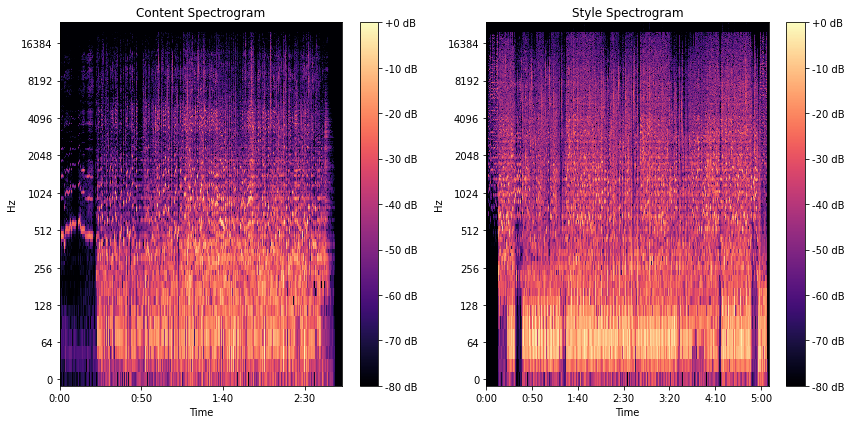

In [3]:
def describe_spectrogram_stats(spectrogram, name):
    """
    Prints descriptive statistics for a given spectrogram.
    """
    print(f"Statistics for {name} Spectrogram:")
    print(f"  Mean: {np.mean(spectrogram):.4f}")
    print(f"  Standard Deviation: {np.std(spectrogram):.4f}")
    print(f"  Minimum Value: {np.min(spectrogram):.4f}")
    print(f"  Maximum Value: {np.max(spectrogram):.4f}")
    print(f"  Median Value: {np.median(spectrogram):.4f}")
    print(f"  Shape: {spectrogram.shape}\n")

# Describe the content spectrogram
describe_spectrogram_stats(content_spectrogram, "Content")

# Describe the style spectrogram
describe_spectrogram_stats(style_spectrogram, "Style")

# Plot the spectrograms
plt.figure(figsize=(12, 6))

# Content Spectrogram
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(content_spectrogram, ref=np.max), 
                         sr=sr, y_axis='log', x_axis='time')
plt.title("Content Spectrogram")
plt.colorbar(format='%+2.0f dB')

# Style Spectrogram
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(style_spectrogram, ref=np.max), 
                         sr=sr, y_axis='log', x_axis='time')
plt.title("Style Spectrogram")
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

Model

In [4]:
import torch
import torch.nn as nn

class StyleTransferNet(nn.Module):
    def __init__(self):
        super(StyleTransferNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x

In [5]:
# Initialize the model
model = StyleTransferNet()

# Check the model structure
print(model)

StyleTransferNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [ ]:
import torch

# Convert to PyTorch tensors and add channel dimension (batch_size, channels, height, width)
content_tensor = torch.tensor(content_spectrogram).unsqueeze(0).unsqueeze(0).float()
style_tensor = torch.tensor(style_spectrogram).unsqueeze(0).unsqueeze(0).float()

# Extract features using the model
content_features = model(content_tensor)
style_features = model(style_tensor)

print("Content Tensor Shape:", content_tensor.shape)
print("Style Tensor Shape:", style_tensor.shape)

In [ ]:
def content_loss(generated_features, content_features):
    return torch.mean((generated_features - content_features) ** 2)

def gram_matrix(features):
    (b, c, h, w) = features.size()
    features = features.view(b * c, h * w)
    gram = torch.mm(features, features.t())
    return gram / (b * c * h * w)

def style_loss(generated_features, style_gram):
    generated_gram = gram_matrix(generated_features)
    return torch.mean((generated_gram - style_gram) ** 2)

In [ ]:
# Initialize the generated spectrogram as a copy of the content spectrogram
generated_tensor = content_tensor.clone().requires_grad_(True)

# Optimizer
optimizer = torch.optim.Adam([generated_tensor], lr=0.01)

# Precompute the style Gram matrix
style_gram = gram_matrix(style_features)

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass for the generated spectrogram
    generated_features = model(generated_tensor)

    # Compute losses
    c_loss = content_loss(generated_features, content_features)
    s_loss = style_loss(generated_features, style_gram)
    total_loss = c_loss + 1e3 * s_loss  # Adjust the style loss weight as needed

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Content Loss: {c_loss.item()}, Style Loss: {s_loss.item()}")

In [ ]:
import librosa

# Convert tensor to numpy array
stylized_spectrogram = generated_tensor.detach().numpy().squeeze()

# Use Griffin-Lim to approximate the phase and reconstruct the audio
stylized_audio = librosa.griffinlim(stylized_spectrogram)

# Save the stylized audio
librosa.output.write_wav("stylized_audio.wav", stylized_audio, sr)